# Steam Search Engine - Evaluation
This document aims to evaluate the performances of the search engine through a series of measures.
The set of queries considered in the computations is defined in "queries.json".
All the measures are applied to the different verions of the project:
- base version, ranking model: BM25F;
- sentiment analysis v1: every game sentiment value is obtained from the average of its reviews sentiment values;
- sentiment analysis v2: every game sentiment value is obatined from the inverted neutral weighted average of its reviews sentiment values.

The following code retrieves the queries set and creates the Benchmarks object.

In [1]:
import os
import json
from BenchmarkUtilities.benchmarks import Benchmarks

# file containing benchmark queries
file_path = os.path.join("BenchmarkUtilities", "queries.json")

with open(file_path) as f:
    queries = json.load(f)

b = Benchmarks(queries)

NB. Per eseguire i benchmark è obbligatorio creare gli indici (indexdir/base e indexdir/sentiment) in precedenza.

In [2]:
indexes = [i for i in range(len(b.queries))]
print("Benchmark queries' indexes:")
print(' '.join(map(str, indexes)))

Benchmark queries' indexes:
0 1 2 3 4 5 6 7 8


In [3]:
try:
    q = 8
    print("User Information Need: " + b.queries[q]["UIN"])
except IndexError as e:
    print(e)
    print("index not valid")

User Information Need: Worst games in Assassin's Creed saga


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



UIN: Worst games in Assassin's Creed saga
Query: assassin creed \sentiment[very bad]
Fields: name
Relevant documents: 260210, 368500, 289650, 277590, 359600, 354380


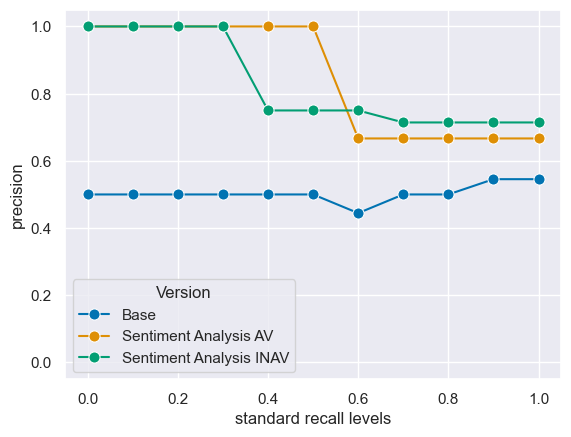

In [4]:
from whoosh.index import open_dir
from MainImplementation.GameSearcher import GameSearcher
import seaborn as sns
import pandas as pd

indexdirBase = "indexdir/base"
indexdirSentiment = "indexdir/sentiment"
if (not os.path.exists(indexdirBase) and not os.path.exists(indexdirSentiment)):
        raise Exception("Index not found")
# create the 2 index objects corresponding to the main index and the sentiment index
main_idxb, reviews_idxb = open_dir(indexdirBase + "/main_index"), open_dir(indexdirBase + "/reviews_index")
main_idxs, reviews_idxs = open_dir(indexdirSentiment + "/main_index"), open_dir(indexdirSentiment + "/reviews_index")

# there is one GameSearcher object for every version of the engine
SearcherBaseVersion = GameSearcher(main_idxb, reviews_idxb)
SearcherSentimentAV = GameSearcher(main_idxs, reviews_idxs, True, "av")
SearcherSentimentINAV = GameSearcher(main_idxs, reviews_idxs, True, "inav")

# search using the benchmark query and its fields
answerB = SearcherBaseVersion.search(b.queries[q]["query"], b.queries[q]["fields"])
answerAV = SearcherSentimentAV.search(b.queries[q]["query"], b.queries[q]["fields"])
answerINAV = SearcherSentimentINAV.search(b.queries[q]["query"], b.queries[q]["fields"])

# exctract the app_id field from the retrieved games
aB = [int(x["app_id"]) for x in answerB]
aAV = [int(x["app_id"]) for x in answerAV]
aINAV = [int(x["app_id"]) for x in answerINAV]

# compute the precision at Standard Recall Levels
pB = b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], aB))
pAV = b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], aAV))
pINAV = b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], aINAV))

# plot the precisions
# apply the default theme
sns.set_theme()

axes = ["standard recall levels", "precision"]

dfB = pd.DataFrame(pB, columns = axes)
dfB["Version"] = "Base"

dfAV = pd.DataFrame(pAV, columns = axes)
dfAV["Version"] = "Sentiment Analysis AV"

dfINAV = pd.DataFrame(pINAV, columns = axes)
dfINAV["Version"] = "Sentiment Analysis INAV"

# create a dataframe for Seaborn
df = pd.concat([dfB, dfAV, dfINAV])

# print the examined query
print()
b.print_query(q)

# plot the line graph
pltP = sns.lineplot(data = df, x = 'standard recall levels', y = 'precision', marker='o', markersize=8, 
             hue="Version", palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltP.set_xlim([-0.05, 1.05]);
pltP.set_ylim([-0.05, 1.05]);

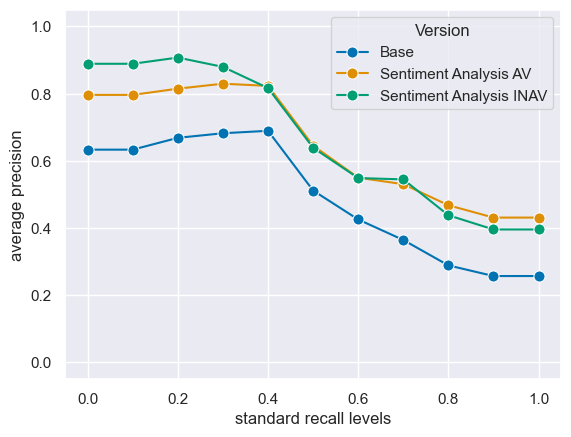

In [6]:
# compute answers list for all the benchmark queries 
answersB = []
answersAV = []
answersINAV = []
for q in range(len(b.queries)):
    answersB.append(SearcherBaseVersion.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersAV.append(SearcherSentimentAV.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersINAV.append(SearcherSentimentINAV.search(b.queries[q]["query"], b.queries[q]["fields"]))

# exctract the app_id field from the retrieved games
asB = []
asAV = []
asINAV = []
for q in range(len(b.queries)):
    asB.append([int(x["app_id"]) for x in answersB[q]])
    asAV.append([int(x["app_id"]) for x in answersAV[q]])
    asINAV.append([int(x["app_id"]) for x in answersINAV[q]])
    
# compute the precision at Standard Recall Levels
psB = []
psAV = []
psINAV = []
for q in range(len(b.queries)):
    psB.append(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asB[q])))
    psAV.append(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asAV[q])))
    psINAV.append(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asINAV[q])))
    
# compute the average precision (for each version) over the benchmark queries set
avpB = b.AveragePrecision(psB)
avpAV = b.AveragePrecision(psAV)
avpINAV = b.AveragePrecision(psINAV)

# plot the average precisions
# apply the default theme
sns.set_theme()

axes = ["standard recall levels", "average precision"]

dfB = pd.DataFrame(avpB, columns = axes)
dfB["Version"] = "Base"

dfAV = pd.DataFrame(avpAV, columns = axes)
dfAV["Version"] = "Sentiment Analysis AV"

dfINAV = pd.DataFrame(avpINAV, columns = axes)
dfINAV["Version"] = "Sentiment Analysis INAV"

# create a dataframe for Seaborn
df = pd.concat([dfB, dfAV, dfINAV])

# plot the line graph
pltAvp = sns.lineplot(data = df, x = 'standard recall levels', y = 'average precision', marker='o', markersize=8, 
             hue="Version", palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltAvp.set_xlim([-0.05, 1.05]);
pltAvp.set_ylim([-0.05, 1.05]);